In [1]:
import sys
import os
import cv2
import time
import glob
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

train_folder = '/home/joohyung/Documents/plant-seedlings/train'
val_folder = '/home/joohyung/Documents/plant-seedlings/validation'
test_folder = '/home/joohyung/Documents/plant-seedlings/test'

def _minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    
    return numerator / (denominator + 1e-7)


def _one_hot(idx):
    idx = tf.one_hot(np.array(idx), 12).eval(session=tf.Session())
    
    return idx

def _shuffle(images, labels):
    tmp = [[x,y] for x, y in zip(images, labels)]
    random.shuffle(tmp)
    shuffle_images = [n[0] for n in tmp]
    shuffle_labels = [n[1] for n in tmp]
    
    return shuffle_images, shuffle_labels

def _data_load(folder_path):
    images = []
    labels = []
    folder_list = os.listdir(folder_path)
    for i, v in enumerate(folder_list):
        image_path = glob.glob(os.path.join(folder_path,v,'*.png')) 
        for j in image_path:
            images.append(cv2.imread(j))
            labels.append(i)
        
    return _minmax_scaler(images), _one_hot(labels)


train_images, train_labels = _data_load(train_folder)
val_images, val_labels = _data_load(val_folder)
test_images, test_labels = _data_load(test_folder)

print("train_images shape: ", np.array(train_images).shape, "// type: ", type(np.array(train_images)))
print("train_labels shape: ", np.array(train_labels).shape, "// type: ", type(np.array(train_labels)))
print("validation_images shape: ", np.array(val_images).shape, "// type: ", type(np.array(val_images)))
print("validation_labels shape: ", np.array(val_labels).shape, "// type: ", type(np.array(val_labels)))
print("test_images shape: ", np.array(test_images).shape, "// type: ", type(np.array(test_images)))
print("test_labels shape: ", np.array(test_labels).shape, "// type: ", type(np.array(test_labels)))

train_images shape:  (3847, 64, 64, 3) // type:  <class 'numpy.ndarray'>
train_labels shape:  (3847, 12) // type:  <class 'numpy.ndarray'>
validation_images shape:  (447, 64, 64, 3) // type:  <class 'numpy.ndarray'>
validation_labels shape:  (447, 12) // type:  <class 'numpy.ndarray'>
test_images shape:  (456, 64, 64, 3) // type:  <class 'numpy.ndarray'>
test_labels shape:  (456, 12) // type:  <class 'numpy.ndarray'>


In [6]:
learning_rate = 0.00001
batch_size = 64
n_epochs = 100

# Create placeholders
X = tf.placeholder(tf.float32,shape=[None,64,64,3], name="image")
Y = tf.placeholder(tf.int32,[None, 12], name="label")
#Y = tf.one_hot(Y, 12).eval(session=tf.Session())
#Y1 = tf.one_hot(Y, 12)
#Y2 = tf.reshape(Y1, [-1, 12])

Kernel1 = tf.get_variable("Kernel1",shape=[3,3,3,64],initializer=tf.contrib.layers.xavier_initializer())
Bias1 = tf.Variable(tf.truncated_normal(shape=[64],stddev=0.1))
Conv1 = tf.nn.conv2d(X, Kernel1, strides=[1,1,1,1], padding='SAME')+Bias1
Activation1 = tf.nn.relu(Conv1)

Pool1 = tf.nn.max_pool(Activation1, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

Kernel2 = tf.get_variable("Kernel2",shape=[3,3,64,128],initializer=tf.contrib.layers.xavier_initializer())
Bias2 = tf.Variable(tf.truncated_normal(shape=[128],stddev=0.1))
Conv2 = tf.nn.conv2d(Pool1, Kernel2, strides=[1,1,1,1], padding='SAME')+Bias2
Activation2 = tf.nn.relu(Conv2)

Pool2 = tf.nn.max_pool(Activation2, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

Kernel3_1 = tf.get_variable("Kernel3_1",shape=[3,3,128,256],initializer=tf.contrib.layers.xavier_initializer())
Bias3_1 = tf.Variable(tf.truncated_normal(shape=[256],stddev=0.1))
Conv3_1 = tf.nn.conv2d(Pool2, Kernel3_1, strides=[1,1,1,1], padding='SAME')+Bias3_1
Activation3_1 = tf.nn.relu(Conv3_1)

Kernel3_2 = tf.get_variable("Kernel3_2",shape=[3,3,256,256],initializer=tf.contrib.layers.xavier_initializer())
Bias3_2 = tf.Variable(tf.truncated_normal(shape=[256],stddev=0.1))
Conv3_2 = tf.nn.conv2d(Activation3_1, Kernel3_2, strides=[1,1,1,1], padding='SAME')+Bias3_2
Activation3_2 = tf.nn.relu(Conv3_2)

Pool3 = tf.nn.max_pool(Activation3_2, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

Kernel4_1 = tf.get_variable("Kernel4_1",shape=[3,3,256,512],initializer=tf.contrib.layers.xavier_initializer())
Bias4_1 = tf.Variable(tf.truncated_normal(shape=[512],stddev=0.1))
Conv4_1 = tf.nn.conv2d(Pool3, Kernel4_1, strides=[1,1,1,1], padding='SAME')+Bias4_1
Activation4_1 = tf.nn.relu(Conv4_1)

Kernel4_2 = tf.get_variable("Kernel4_2",shape=[3,3,512,512],initializer=tf.contrib.layers.xavier_initializer())
Bias4_2 = tf.Variable(tf.truncated_normal(shape=[512],stddev=0.1))
Conv4_2 = tf.nn.conv2d(Activation4_1, Kernel4_2, strides=[1,1,1,1], padding='SAME')+Bias4_2
Activation4_2 = tf.nn.relu(Conv4_2)

Pool4 = tf.nn.max_pool(Activation4_2, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

Kernel5_1 = tf.get_variable("Kernel5_1",shape=[3,3,512,512],initializer=tf.contrib.layers.xavier_initializer())
Bias5_1 = tf.Variable(tf.truncated_normal(shape=[512],stddev=0.1))
Conv5_1 = tf.nn.conv2d(Pool4, Kernel5_1, strides=[1,1,1,1], padding='SAME')+Bias5_1
Activation5_1 = tf.nn.relu(Conv5_1)

Kernel5_2 = tf.get_variable("Kernel5_2",shape=[3,3,512,512],initializer=tf.contrib.layers.xavier_initializer())
Bias5_2 = tf.Variable(tf.truncated_normal(shape=[512],stddev=0.1))
Conv5_2 = tf.nn.conv2d(Activation5_1, Kernel5_2, strides=[1,1,1,1], padding='SAME')+Bias5_2
Activation5_2 = tf.nn.relu(Conv5_2)

Pool5 = tf.nn.max_pool(Activation5_2, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

W1 = tf.get_variable("W1",shape=[2*2*512, 1024],initializer=tf.contrib.layers.xavier_initializer())
B1 = tf.Variable(tf.truncated_normal(shape=[1024]))
Pool5_flat = tf.reshape(Pool5,[-1,2*2*512])
fc6 = tf.matmul(Pool5_flat,W1)+B1
Activation6 = tf.nn.relu(fc6)

W2 = tf.get_variable("W2",shape=[1024, 12],initializer=tf.contrib.layers.xavier_initializer())
B2 = tf.Variable(tf.truncated_normal(shape=[12]))
OutputLayer = tf.matmul(Activation6 ,W2)+B2

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=OutputLayer, labels=Y))
#optimizer = tf. train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9).minimize(loss)
optimizer = tf. train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(OutputLayer,1),tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

ValueError: Variable Kernel1 already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-2-fa53114d59bc>", line 12, in <module>
    Kernel1 = tf.get_variable("Kernel1",shape=[3,3,3,64],initializer=tf.contrib.layers.xavier_initializer())
  File "/home/joohyung/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/joohyung/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):


In [7]:
# Run optimization and test
loss_train_history = []
acc_train_history = []
loss_val_history = []
acc_val_history = []

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    n_batches = int(len(train_images)/batch_size)
    
    for i in range(n_epochs):  
        total_correct_train_preds = 0
        x_train, y_train =_shuffle(train_images, train_labels)
        for k in range(n_batches):
            X_train_batch, Y_train_batch = x_train[k*batch_size:k*batch_size+batch_size], \
                                           y_train[k*batch_size:k*batch_size+batch_size] 
            _, loss_train, OutputLayer_train_batch = sess.run([optimizer, loss, accuracy], \
                                                              feed_dict={X: X_train_batch, Y: Y_train_batch})
            total_correct_train_preds += OutputLayer_train_batch
        train_accuracy = total_correct_train_preds/n_batches
                
        
        # Check validation accuracy
        n_v_batches = int(len(val_images)/batch_size)
        total_correct_val_preds = 0
        for j in range(n_v_batches):
            X_val_batch, Y_val_batch = val_images[j*batch_size:j*batch_size+batch_size], \
                                       val_labels[j*batch_size:j*batch_size+batch_size] 
            loss_val, OutputLayer_val_batch = sess.run([loss, accuracy], feed_dict={X: X_val_batch, \
                                                                                    Y: Y_val_batch})
            total_correct_val_preds += OutputLayer_val_batch
        validation_accuracy = total_correct_val_preds/n_v_batches
           
        print('epoch:%d // train loss:%.3f // train accuracy:%.3f // val loss:%.3f // val accuracy:%.3f' \
              % (i, loss_train, train_accuracy, loss_val, validation_accuracy))
        loss_train_history.append(loss_train)
        acc_train_history.append(train_accuracy)
        loss_val_history.append(loss_val)
        acc_val_history.append(validation_accuracy)
        
        


    # Test the model
    n_batches = int(len(test_images)/batch_size)
    total_correct_test_preds = 0
    for i in range(n_batches):
        X_test_batch, Y_test_batch = test_images[i*batch_size:i*batch_size+batch_size], \
                                     test_labels[i*batch_size:i*batch_size+batch_size]
        OutputLayer_test_batch = sess.run(OutputLayer, feed_dict={X: X_test_batch, Y:Y_test_batch})
        preds = tf.nn.softmax(OutputLayer_test_batch)
        correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y_test_batch, 1))
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
        total_correct_test_preds += sess.run(accuracy)
        
    print ("Test accuracy is {0}".format(total_correct_test_preds/len(test_images)))


InvalidArgumentError: You must feed a value for placeholder tensor 'label' with dtype int32 and shape [?,12]
	 [[Node: label = Placeholder[dtype=DT_INT32, shape=[?,12], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: gradients/add_grad/Shape/_17 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_137_gradients/add_grad/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'label', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/joohyung/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/joohyung/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/joohyung/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/joohyung/.local/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/joohyung/.local/lib/python3.5/site-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/home/joohyung/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/joohyung/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/home/joohyung/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/joohyung/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/joohyung/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/joohyung/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/joohyung/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/joohyung/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/joohyung/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/joohyung/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/joohyung/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/joohyung/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/joohyung/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/joohyung/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/joohyung/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-fa53114d59bc>", line 7, in <module>
    Y = tf.placeholder(tf.int32,[None, 12], name="label")
  File "/home/joohyung/.local/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1808, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/joohyung/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4848, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/joohyung/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/joohyung/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/joohyung/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'label' with dtype int32 and shape [?,12]
	 [[Node: label = Placeholder[dtype=DT_INT32, shape=[?,12], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: gradients/add_grad/Shape/_17 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_137_gradients/add_grad/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


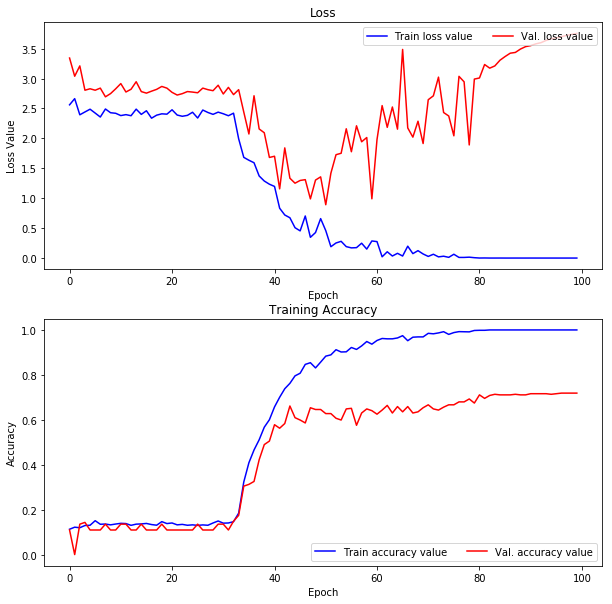

In [5]:
plt.subplot(2,1,1)
plt.plot(loss_train_history, 'b-', label='Train loss value')
plt.plot(loss_val_history, 'r-', label='Val. loss value')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(ncol=2, loc='upper right')

plt.subplot(2,1,2)
plt.plot(acc_train_history, 'b-', label='Train accuracy value')
plt.plot(acc_val_history, 'r-', label='Val. accuracy value')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(10, 10)
plt.show()